In [1]:
import sys
sys.path.append('../src')
from satellite_image import SatelliteImage
from utils import *
from plot_utils import *

import yaml
import re
import s3fs
import numpy as np
import matplotlib.pyplot as plt
#import cv2
from PIL import Image as im

from datetime import date
import re
import pyproj


In [2]:
update_storage_access()
environment = get_environment()

root_path = get_root_path()
bucket = environment["bucket"]
path_s3_cayenne_data = environment["sources"]["PLEIADES"][2022]["guyane"]
path_local_cayenne_data = os.path.join(root_path, environment["local-path"]["PLEIADES"][2022]["guyane"])

bucket = environment["bucket"]

path_s3_pleiades_data_2022_guyane = environment["sources"]["PLEIADES"][2022]["guyane"]
path_s3_bdtopo_data_2022_guyane = environment["sources"]["BDTOPO"][2022]["guyane"]
path_local_pleiades_data_2022_guyane = environment["local-path"]["PLEIADES"][2022]["guyane"]
path_local_bdtopo_data_2022_guyane = environment["local-path"]["BDTOPO"][2022]["guyane"]

path_s3_pleiades_data_2022_martinique = environment["sources"]["PLEIADES"][2022]["martinique"]
path_local_pleiades_data_2022_martinique = environment["local-path"]["PLEIADES"][2022]["martinique"]

path_s3_pleiades_data_2017_martinique = environment["sources"]["PLEIADES"][2017]["martinique"]
path_local_pleiades_data_2017_martinique = environment["local-path"]["PLEIADES"][2017]["martinique"]

fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})

In [ ]:
# DL PLEIADE martinique 2017
fs.download(
        rpath=f"{bucket}/{path_s3_pleiades_data_2017_martinique}",
        lpath=f"../{path_local_pleiades_data_2017_martinique}",
        recursive=True)

# DL PLEIADE martinique 2022
fs.download(
        rpath=f"{bucket}/{path_s3_pleiades_data_2022_martinique}",
        lpath=f"../{path_local_pleiades_data_2022_martinique}",
        recursive=True)

In [3]:

#crs = 5490 pour la martinique
def gps_to_crs_point(lat,lon,crs) :
    
    # Définir les systèmes de coordonnées de départ et d'arrivée
    src_proj = pyproj.Proj(proj='latlong')
    dest_proj = pyproj.Proj(crs)
    
    # Convertir les coordonnées GPS en coordonnées dans le système de coordonnées de destination (CRS)
    x, y = pyproj.transform(src_proj, dest_proj, lon, lat)
    
    # Retourner les coordonnées dans le CRS spécifié
    return x, y

#ca serait bien de faire une fonction qui cherche dans l'ensemble des données l'image qui contiendra cette coordonées.

def find_image_of_point(coordinate, folder_path, coord_gps = False, crs = None) :
    
    if coord_gps == True :  
        lat, lon = coordinate
        x,y = gps_to_crs_point(lat,lon,crs) #car y=lat et x=lon, les coordonnées gps sont en (lat,lon)
    else :
        x,y = coordinate
                                          
    for filename in os.listdir(folder_path):
        # Define a list of delimiter characters
        delimiters = ["-", "_"]

        # Create a regular expression pattern from the delimiter characters
        pattern = "|".join(delimiters)

        # Split the string using the regular expression pattern
        split_filename = re.split(pattern, filename)
        
        left = float(split_filename[2])*1000
        top = float(split_filename[3])*1000
        right = left + 1000.0
        bottom = top - 1000.0
         
        if left <= x <= right:
            if bottom <= y <= top:
                return(folder_path + '/' +filename)
    else : 
        return("Le point n'est pas retrouvé dans ce fichier d'images")
           


/tmp/ipykernel_1809/2119366160.py:9: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(src_proj, dest_proj, lon, lat)
/tmp/ipykernel_1809/2119366160.py:9: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(src_proj, dest_proj, lon, lat)


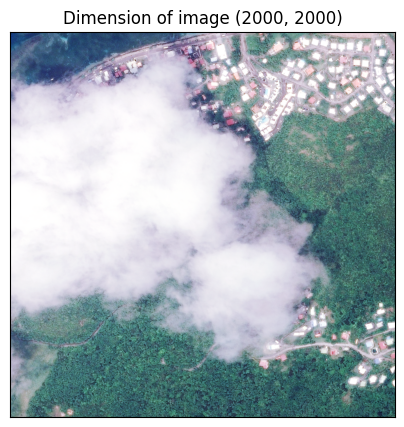

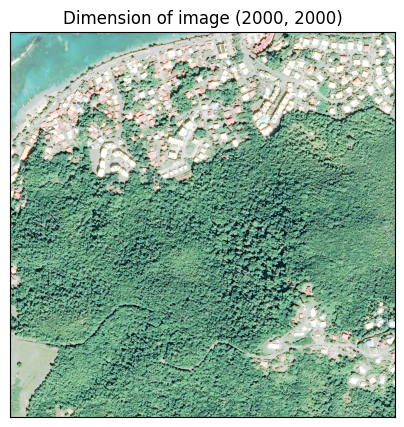

In [6]:
#
# 14.769096787469728, -60.90006133637827 -> badant nuages..
# 14.760965395697703, -60.9138387873933 -> idem..
coordinate  = (14.760965395697703, -60.9138387873933)
folder_path1 = "../data/PLEIADES/2017/MARTINIQUE"
folder_path2 = "../data/PLEIADES/2022/MARTINIQUE"
coord_gps = True
path_t = find_image_of_point(
                                   coordinate,
                                   folder_path1,
                                   coord_gps,
                                    crs = 5490
                                  )
path_tplus1= find_image_of_point(
                                   coordinate,
                                   folder_path2,
                                   coord_gps,
                                crs = 5490
                                  )

#fromraster !!
#on recharge l'image originale
image_t = SatelliteImage.from_raster(
        path_t,
        date = 2017, 
        n_bands = 3,
        dep = "972"
    )
image_tplus1 = SatelliteImage.from_raster(
        path_tplus1,
        date = 2022, 
        n_bands = 3,
        dep = "972"
    )


image_t.plot([0,1,2])
image_tplus1.plot([0,1,2])